# Text Mining and Regression using Dimensionality Reduction Methods 




#### In this project I will study apply dimensionality reduction methods to improve my understanding of text data and to predict the sentiment of a set of texts. The dataset for this project comes from the Amazon website and represents 1,000 reviews which were labeled (by humans) as positive or negative. This project practices the method called [sentiment analysis](https://en.wikipedia.org/wiki/Sentiment_analysis). Sentiment analysis is widely used across many fields to get automated feedback when text opinions are expressed. I will also work with dimensionality reduction for classification and regression.
---

In [1]:
import numpy as np
import pandas as pd
import umap.umap_ as umap
from sklearn.decomposition import PCA, TruncatedSVD
import sklearn.feature_extraction.text as sktext
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score
from itertools import product

import seaborn as sns
import matplotlib.pyplot as plt
seed = 221113


The dataset comes with the text and a binary variable which represents the sentiment, either positive or negative. I am using sklearn's `TfidfVectorizer` to eliminate accents, special characters, and stopwords, converting the raw documents to a matrix of TF-IDF features. In addition, I am also making sure to eliminate words that appear in less than 5% of documents and those that appear in over 95%. I will set `sublinear_tf` to `True` for logarithmic increase in Tfidf score compared to the term frequency.. After that, split the data into train and test with `test_size = 0.2` and `seed = seed`. Calculate the [Tf-Idf transform](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html) for both train and test. I will fit and transform the inputs for the test set..


In [3]:


reviews = pd.read_csv("Reviews_sample.csv")

reviews.head(n=5)

,text,label
0,Stuning even for the non-gamer: This sound tr...,1
1,The best soundtrack ever to anything.: I'm re...,1
2,Amazing!: This soundtrack is my favorite musi...,1
3,Excellent Soundtrack: I truly like this sound...,1
4,"Remember, Pull Your Jaw Off The Floor After H...",1


In [4]:
# Defining the TfIDFTransformer 
TfIDFTransformer = sktext.TfidfVectorizer(strip_accents='unicode', # removes accents and special characters
                      stop_words='english', # removestop words
                      min_df = 0.05, # removes words that appear < 5% of texts
                      max_df = 0.90, # removes words that appear > 95% of texts
                      sublinear_tf=True #logarithmic increase in Tfidf score compared to the term frequency. tf = 1 + log(tf)
                      )

# Train/test spliting data
X = reviews.drop('label', axis=1).values
y = reviews['label'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

#calculating td-IDF transformation
#fitting and transforming training data and turning it into a dense matrix
X_train_flat=X_train.ravel()
X_train_TfIDF= TfIDFTransformer.fit_transform(X_train_flat).toarray()
#transforming test data and turning into dense matrix
X_test_flat=X_test.ravel()
X_test_TfIDF= TfIDFTransformer.transform(X_test_flat).toarray()

From here on, you will use the variables `TfIDF_train` and `TfIDF_test` as the input for the different tasks, and the `y_train` and `y_test` labels for each dataset (if required). Print the number of indices in the ouput using [`TfIDFTransformer.get_feature_names()` method](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html).

In [5]:
# using the tfidf)train and tests as the input for the following tasks
word_index = TfIDFTransformer.get_feature_names_out()
print('the number of indices are:', word_index.shape[0])

the number of indices are: 65


With the tfIDF matrix I will explore what some commonly occuring concepts are in the text reviews. I will do this using a PCA transform of the TF-IDF matrix. It will give me a basis of the text data, each component representing a *concept* or set of words that are correlated. Correlation in text can be interpreted as a relation to a similar topic. I will calculate a PCA transform of the training data using the **maximum** number of concepts possible. I will then make a plot of the explained variance that shows the cumulative explained variance per number of concepts.

In [6]:
 TfIDF_train = X_train_TfIDF
 TfIDF_test= X_test_TfIDF

 TfIDF_test.shape

(200, 65)

Total variance explained by the first 65 components is 0.889.


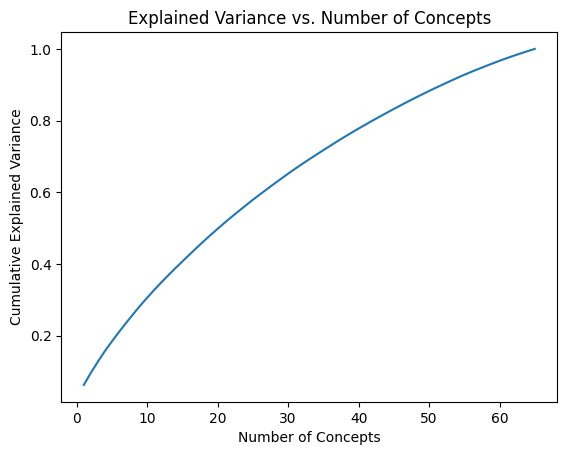

In [7]:

#selecting maximun number of concepts (number of indices )
max_concepts = 65
pca = PCA(n_components=max_concepts, svd_solver='full')
pca.fit(TfIDF_train)

# Plotting explained variance with number of concepts 
#calculating variance of all components
total_variance = np.sum(pca.explained_variance_)
print('Total variance explained by the first %i components is %.3f.' % (pca.n_components_, total_variance))


cumulative_variance = np.cumsum(pca.explained_variance_ratio_)


df = pd.DataFrame({'Cumulative Variance': cumulative_variance}, index=range(1, len(cumulative_variance)+1))

sns.lineplot(data=df, x=df.index, y='Cumulative Variance', markers=' ')
plt.xlabel('Number of Concepts')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs. Number of Concepts')
plt.show()

In [8]:
#getting the exact index where the variance is above 80%

# Finding the index of the first element greater than or equal to 0.8
idx = df[df['Cumulative Variance'] >= 0.8].index.min()

# Subtractting 1 to get the index of the last element less than 0.8
idx -= 1

print("The index where the variance is 0.8 is: ", idx, "we need exactly: ", idx, "concepts to correctly explain 80% of the data" )

The index where the variance is 0.8 is:  41 we need exactly:  41 concepts to correctly explain 80% of the data


showing the 10 words that are the most important in each of these three concepts (as revealed by the absolute value of the PCA weight in each concept).


In [9]:

#explained variance for first 3 componentss
explained_variance_ratio_3 = pca.explained_variance_ratio_[:3]

print("Explained Variance Ratio for First 3 Concepts:")
for i, ratio in enumerate(explained_variance_ratio_3):
    print(f"Concept {i+1}: {ratio:.4f}")


cumulative_var = np.sum(explained_variance_ratio_3)*100
print("\nThe cumulative variance of these 3 concepts is: %.3f." % cumulative_var,"%")

Explained Variance Ratio for First 3 Concepts:
Concept 1: 0.0627
Concept 2: 0.0338
Concept 3: 0.0312

The cumulative variance of these 3 concepts is: 12.766. %


In [10]:
# Getting 10 most important words for each component 

sorted_indices_of_weight = []


for i in range(3):
   weights = pca.components_[i]
   abs_weight = np.abs(weights)

   # indices of the sorted elements in descending order
   sorted_indices = np.argsort(abs_weight)[::-1]

    #absolute value of the weights
   sorted_indices_of_weight.append(sorted_indices)


#storing first 10 sorted indicies of weight in var for each concept
concept_1 = sorted_indices_of_weight[0][:10]
concept_2 = sorted_indices_of_weight[1][:10]
concept_3 = sorted_indices_of_weight[2][:10]

#print(concept_1, "\n", concept_2, '\n', concept_3)

#feature_names = pca.get_feature_names_out()


In [11]:
# Words for concept 1
print("The 10 words most important in concept 1 are: ")
words = word_index[concept_1]
for i, word in enumerate(words):
    print(f"{i+1}. {word}")

The 10 words most important in concept 1 are: 
1. book
2. read
3. product
4. movie
5. reading
6. buy
7. written
8. bought
9. just
10. wear


In [12]:
# Words for concept 2
print("The 10 words most important in concept 2 are: ")
words = word_index[concept_2]
for i, word in enumerate(words):
    print(f"{i+1}. {word}")

The 10 words most important in concept 2 are: 
1. movie
2. product
3. wear
4. great
5. bought
6. worst
7. better
8. buy
9. day
10. people


In [13]:
# Words for concept 3 
print("The 10 words most important in concept 3 are: ")
words = word_index[concept_3]
for i, word in enumerate(words):
    print(f"{i+1}. {word}")

The 10 words most important in concept 3 are: 
1. great
2. love
3. don
4. movie
5. money
6. like
7. book
8. really
9. just
10. know



The cumulative variance is 12.766%. I would name concept 1:  "Book Reviews" as the words [book, read, reading, written] are included. I would name concept 2: "Product Reviews" as the words [product, buy, great] are included. I would name concept 3: "Media Reviews" as is includes words like [don, movie, great, love]

Apply the PCA transformation to the test dataset. Using only the first two components and making a scatter plot of the cases. Identifying positive and negative cases by colouring points with different sentiments with different colours.


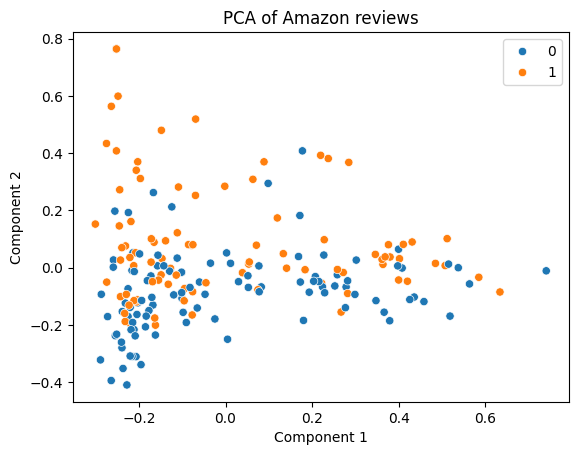

In [14]:
# Apply PCA to the test dataset 
num_concepts = 2
pca = PCA(n_components=num_concepts, svd_solver='full')
pca.fit(TfIDF_test)

# Plotting the two different set of points with different markers and labels 
Z1 = pca.transform(TfIDF_test)
sns.scatterplot(x=Z1[:, 0], y=Z1[:, 1], hue=y_test)

plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.title("PCA of Amazon reviews")
plt.show()

The negative reviews are clustered more in the bottom left, which means they have lower values for both Component 1 and Component 2.
The positive reviews have higher values for both Component 1 and Component 2, which means they are more spread out in the plot.
We cannot use only two components to perfectly discriminate between positive and negative reviews if 41 components are needed to explain 80% of the data. However, we can try to determine whethere these two components capture the most important sources of variation in the data by training a classifier on the two components and evaluating its performance.

Repeating the process above, only now using a UMAP projection with two components. Testing all combinations of ```n_neighbors=[2, 10, 25]``` and ```min_dist=[0.1, 0.25, 0.5]``` over the train data and choosing the projection that I think is best, and applying it over the test data. Using 1000 epochs, a cosine metric and random initialization. 



/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} over

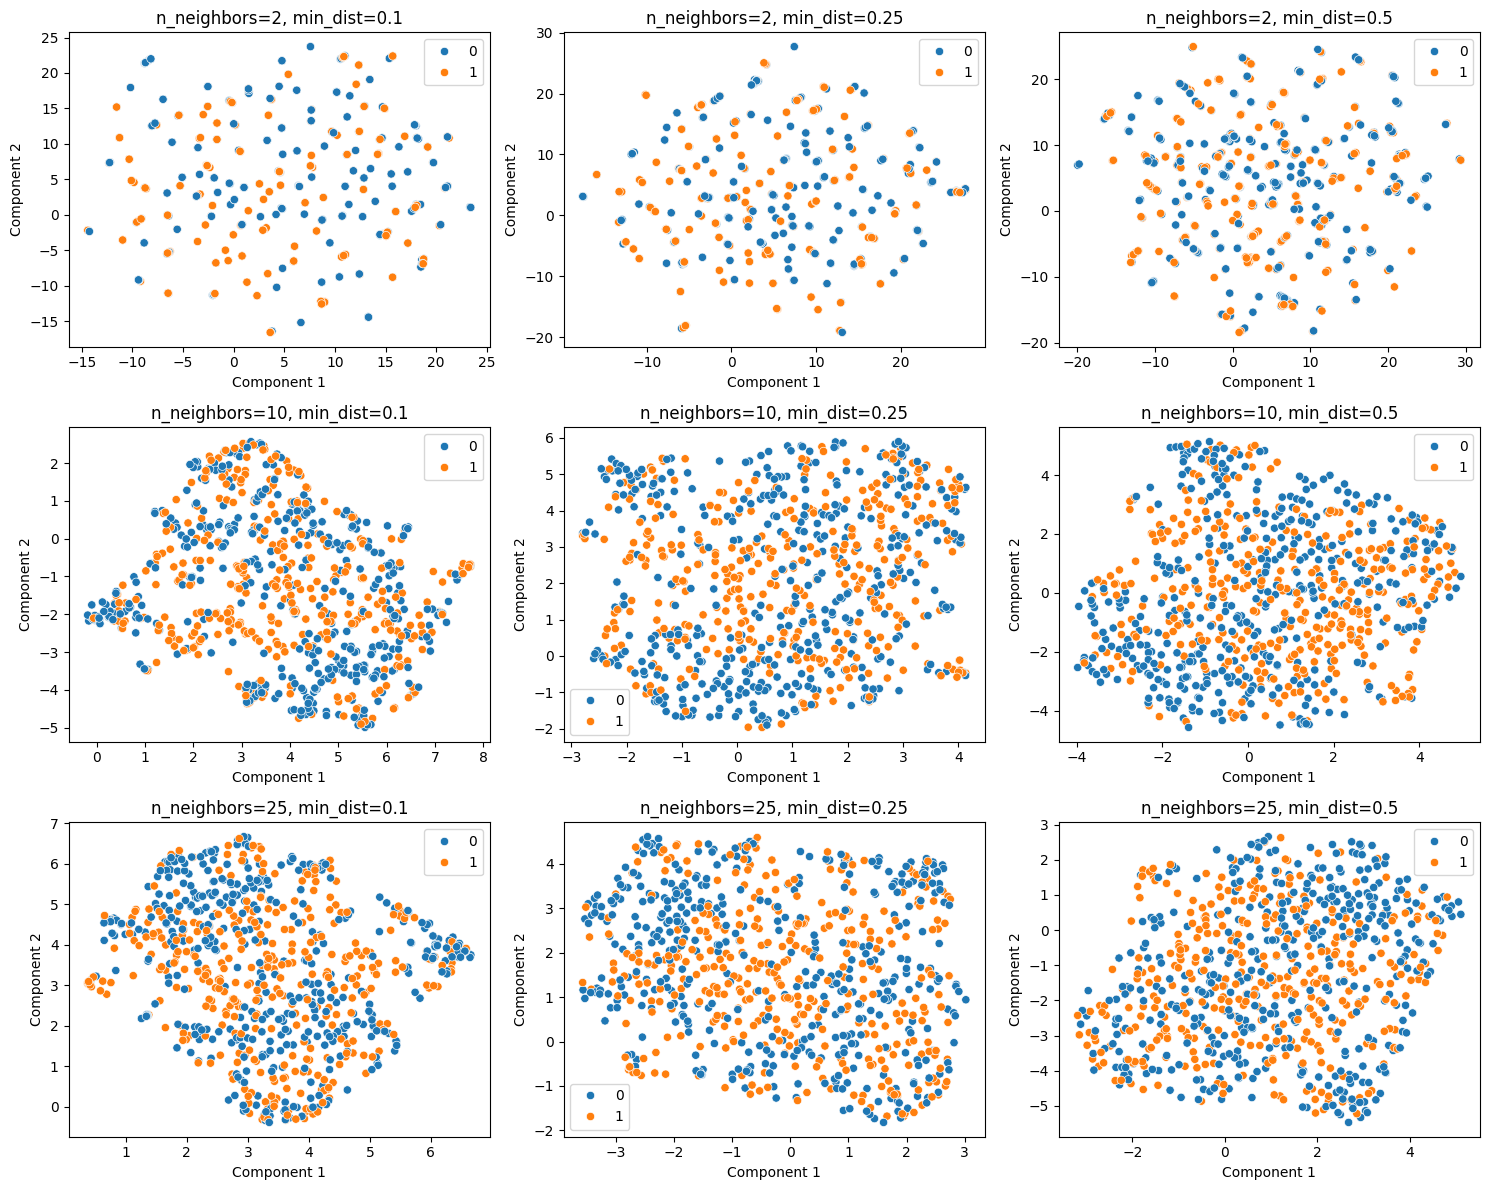

In [15]:
import itertools

n_neighbors_options = [2, 10, 25]
min_dist_options = [0.1, 0.25, 0.5]

fig, axes = plt.subplots(len(n_neighbors_options), len(min_dist_options), figsize=(15, 12))

# Iterating through all combinations of n_neighbors and min_dist
for i, (n_neighbors, min_dist) in enumerate(itertools.product(n_neighbors_options, min_dist_options)):
    #
    reducer = umap.UMAP(n_neighbors=n_neighbors,
                        n_components=2,
                        metric='cosine',
                        n_epochs=1000,
                        min_dist=min_dist,
                        low_memory=True,
                        n_jobs=-1,
                        random_state=seed,
                        verbose=False)

    # trainig and calculating embedding
    UMAP_embedding = reducer.fit_transform(TfIDF_train)


    row_index = i // len(min_dist_options)
    col_index = i % len(min_dist_options)
    sns.scatterplot(x=UMAP_embedding[:, 0], y=UMAP_embedding[:, 1], hue=y_train, ax=axes[row_index, col_index])
    axes[row_index, col_index].set_title(f"n_neighbors={n_neighbors}, min_dist={min_dist}")
    axes[row_index, col_index].set_xlabel("Component 1")
    axes[row_index, col_index].set_ylabel("Component 2")


plt.tight_layout()
plt.show()


I would choose parameters n_neighbors=10, min_dist=0.1. This UMAP visualization shows the positive and negative labels clustered with like points the most clear to me.

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


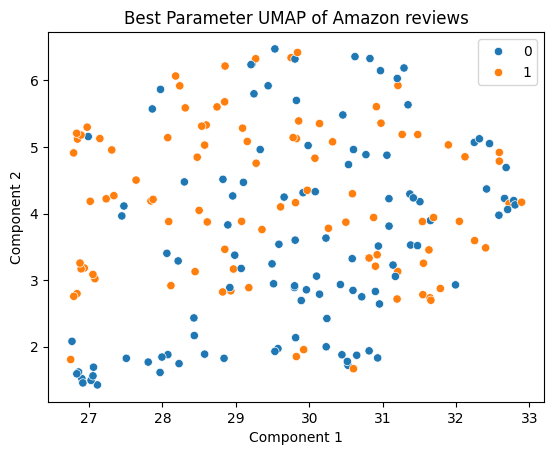

In [16]:
#choosing parameters n_neighbors=10, min_dist=0.1 to build UMAP of

n = 10
m = 0.1
best_reducer = umap.UMAP(n_neighbors=n,
                         n_components=2,
                         metric='cosine',
                         n_epochs=1000,
                         min_dist=m,
                         random_state=seed,
                         verbose=False)
UMAP_embedding_test = best_reducer.fit_transform(TfIDF_test)

# Create plot [ /1 marks]
sns.scatterplot(x=UMAP_embedding_test[:, 0], y=UMAP_embedding_test[:, 1], hue=y_test)
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.title("Best Parameter UMAP of Amazon reviews")
plt.show()

The PCA plot captures a global structure while the UMAP plot appears to be more sparse and scattered. UMAP is capturing more complex or nonlinear relationships in the data compared to PCA.


I will now benchmark the predictive capabilities of the compressed data against the original one.



I will train a regularized logistic regression over the original TfIDF train set (with no compression) using l2 regularization. I will calculate the AUC score and plot the ROC curve for the original test set. I am using the previous train/test split. 

AUC score: 0.7811777710782836


Text(0.5, 1.0, 'ROC Curve for Regularized Logistic Regression on Scaled Dataset')

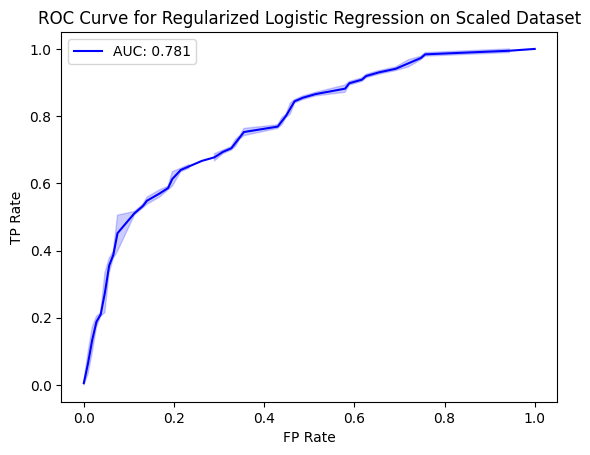

In [17]:

from sklearn.preprocessing import StandardScaler

# Defining the model
model = LogisticRegressionCV(penalty='l2')

#scaling data
scaler = StandardScaler()
scaler.fit(TfIDF_train)

TfIDF_train_scaled = scaler.transform(TfIDF_train)
TfIDF_test_scaled = scaler.transform(TfIDF_test)

# Fitting on the training dataset

model.fit(TfIDF_train_scaled, y_train)

# Applying to the test dataset
pred = model.predict(TfIDF_test_scaled)

# Ploting ROC curve and computeingAUC score 
pred_proba = model.predict_proba(TfIDF_test_scaled)[:,1]

fpr, tpr, thresholds = roc_curve(y_test, pred_proba)

# Save the AUC in a variable to display it. Round it first
auc = roc_auc_score(y_test, pred_proba)
auc_formatted = "{:.3f}".format(auc)
print("AUC score:", auc)

label = 'AUC: ' + auc_formatted

ax = sns.lineplot(x=fpr, y=tpr, color="blue",  label=label)
ax.set_xlabel("FP Rate")
ax.set_ylabel("TP Rate")
ax.set_title("ROC Curve for Regularized Logistic Regression on Scaled Dataset")

I will now train a regularized logistic regression over an SVD-reduced dataset (with 10 components) using l2 regularization. I will calculate the AUC score and plot the ROC curve for the SVD-transformed test set.

AUC score: 0.7603758416239574


Text(0.5, 1.0, 'ROC Curve for Regularized Logistic Regression on SVD-Reduced Dataset')

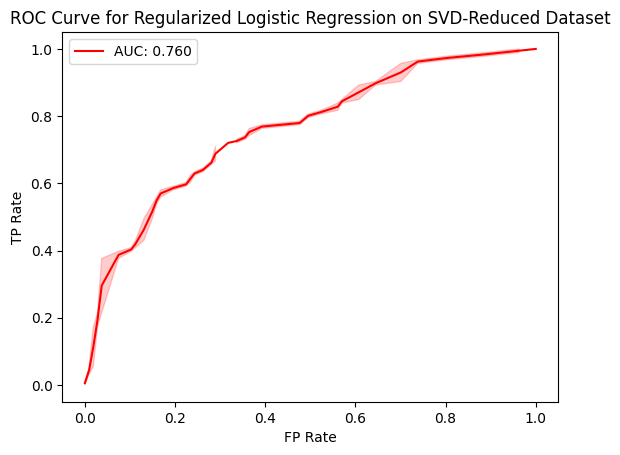

In [18]:
from sklearn.linear_model import LogisticRegression


#fitting model on training data
svd = TruncatedSVD(n_components=10, n_iter=10, random_state=seed)
svd.fit(TfIDF_train)

#performing dimensionality reduction on X training and test set
TfIDF_train_reduced = svd.transform(TfIDF_train)
TfIDF_test_reduced = svd.transform(TfIDF_test)

#Training and testing using model LogisticRegressionCV
model2 = LogisticRegression(penalty='l2',  random_state=seed)
model2.fit(TfIDF_train_reduced, y_train)
pred2 = model2.predict(TfIDF_test_reduced)



pred_proba2 = model2.predict_proba(TfIDF_test_reduced)[:,1]

fpr2, tpr2, thresholds2 = roc_curve(y_test, pred_proba2)


auc2 = roc_auc_score(y_test, pred_proba2)
auc_formatted2 = "{:.3f}".format(auc2)
print("AUC score:", auc2)

label2 = 'AUC: ' + auc_formatted2

ax = sns.lineplot(x=fpr2, y=tpr2, color="red",  label=label2)
ax.set_xlabel("FP Rate")
ax.set_ylabel("TP Rate")
ax.set_title("ROC Curve for Regularized Logistic Regression on SVD-Reduced Dataset")


I will now train a regularized logistic regression over the UMAP-reduced dataset (with 10 components using the same parameters as Task 1.5) using l2 regularization. 

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-reg

AUC score: 0.589990955682846


Text(0.5, 1.0, 'ROC Curve for Regularized Logistic Regression on UMAP-Reduced Dataset')

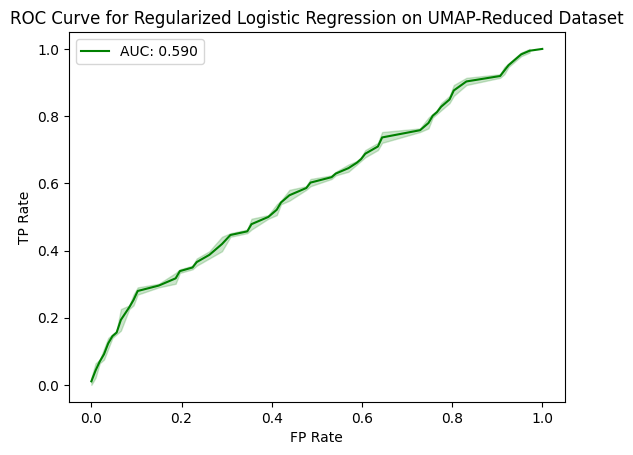

In [19]:

n = 10
m = 0.1
reducer = umap.UMAP(n_neighbors=n,
                         n_components=10,
                         metric='cosine',
                         n_epochs=1000,
                         min_dist=m,
                         random_state=seed,
                         verbose=False)

UMAP_train = reducer.fit_transform(TfIDF_train)
UMAP_test = reducer.fit_transform(TfIDF_test)



model3 = LogisticRegressionCV(penalty='l2', random_state=seed)



model3.fit(UMAP_train, y_train)


pred3 = model3.predict(UMAP_test)



pred_proba3 = model3.predict_proba(UMAP_test)[:, 1]
fpr3, tpr3, thresholds2 = roc_curve(y_test, pred_proba3)

auc3 = roc_auc_score(y_test, pred_proba3)
auc_formatted3 = "{:.3f}".format(auc3)
print("AUC score:", auc3)

label3 = 'AUC: ' + auc_formatted3

ax = sns.lineplot(x=fpr3, y=tpr3, color="green",  label=label3)
ax.set_xlabel("FP Rate")
ax.set_ylabel("TP Rate")
ax.set_title("ROC Curve for Regularized Logistic Regression on UMAP-Reduced Dataset")

**3 Model Analysis:**
After comparing the performance of all three models, the logistic regression model trained on the scaled dataset performs the best with a AUC score of 0.781. UMAP can also introduce some noise into the data, which can make it more difficult for logistic regression models to learn the relationships between the features and the target variable, Thus having a AUC score of 0.590.




In [20]:
df = pd.read_csv('/Hockey_sample.csv')

#dropping categorical attributes
df = df.select_dtypes(include=["number"], exclude=["object"])

#standardizing numerical attributes
scaler = StandardScaler()
scaled_df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

#creating matrix of predictors with y = target
y = scaled_df['icetime'].values
X1 = scaled_df.drop(columns=["icetime"], axis=1).values

print('Shape of X1:', X1.shape)
print('Shape of y:', y.shape)


Shape of X1: (2725, 24)
Shape of y: (2725,)



Using a 15-component regular PCA to transform `X1` and create the scree plot. Let $p$ be the **minimum** number of PCs required in order to capture at least 80% of total variance.Determining Value of P and reducing the dimension of `X1` to $p$ and calling this new array `X2`. 

The value of p, the # of PCs required to capture at least 80% of total variance is:  11


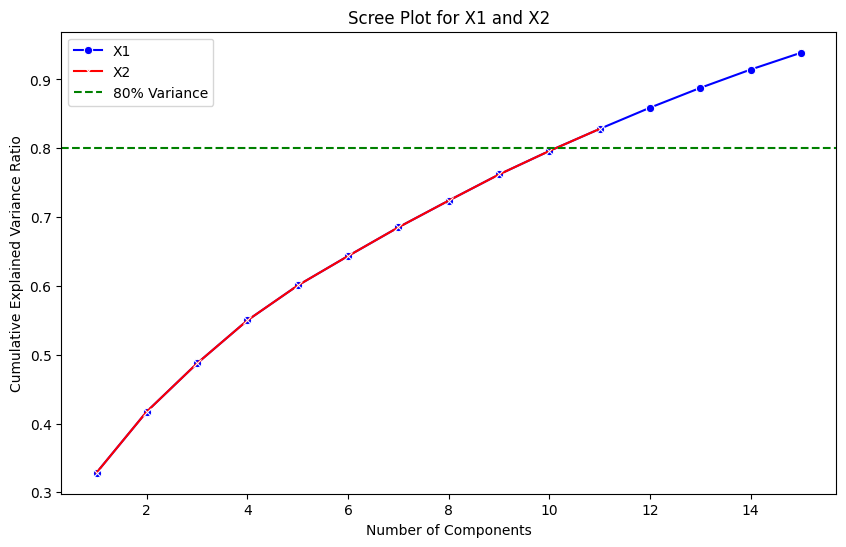

In [21]:
#transforming X1 with PCA for 15 components
num_concepts = 15
pca1 = PCA(n_components=num_concepts)
pca1.fit(X1)

# minimum number of PCs required to capture at least 80% of total variance
p = np.argmax(np.cumsum(pca1.explained_variance_ratio_) >= 0.8) + 1
print("The value of p, the # of PCs required to capture at least 80% of total variance is: ", p)
# Reducing the dimension of X1 to p
pca2 = PCA(n_components=p)
X2 = pca2.fit_transform(X1)


fig, ax = plt.subplots(figsize=(10, 6))

# explained variance ratio plot for X1
sns.lineplot(x=range(1, num_concepts + 1), y=np.cumsum(pca1.explained_variance_ratio_), marker='o', color='blue', label='X1', ax=ax)

# explained variance ratio plot for X2
sns.lineplot(x=range(1, p + 1), y=np.cumsum(pca2.explained_variance_ratio_), marker='x', color='red', label='X2', ax=ax)

ax.set_xlabel('Number of Components')
ax.set_ylabel('Cumulative Explained Variance Ratio')
ax.set_title('Scree Plot for X1 and X2')
ax.axhline(y=0.8, color='green', linestyle='--', label='80% Variance')
ax.legend()
plt.show()


I have 2 different design matrices (*i.e.*, `X1` and `X2`). Training a simple linear regression (with default arguments) once using `X1`, and another time using the combination of `X1` and `X2`. Using cross-validation with RMSE as the error measure to identify the best model among the two. Reporting the cross-validation RMSE along with thier CIs for both models.

In [22]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
#concatenating X1 and X2
x1x2 = np.concatenate((X1, X2), axis =1)

#splitting data into train and test split
X1_train, X1_test, y_train, y_test = train_test_split(X1, y)
X2_train, X2_test, y_train, y_test = train_test_split(x1x2, y)

#scaling data for X1 train/test split
scaler1 = StandardScaler()
scaler1.fit(X1_train)

X1_train_scaled = scaler1.transform(X1_train)
X1_test_scaled = scaler1.transform(X1_test)

#scaling data for X2 train/test split
scaler2 = StandardScaler()
scaler2.fit(X2_train)

X2_train_scaled = scaler2.transform(X2_train)
X2_test_scaled = scaler2.transform(X2_test)


#scenario 1: Linear Regression using X1
m1 = LinearRegression().fit(X1_train_scaled, y_train)

#Scenario 2: Linear Regression using X1X2 concatenated
m2 = LinearRegression().fit(X2_train_scaled, y_train)

# Predicting the target variable on the test sets and calculating loss on test set
y_pred1 = m1.predict(X1_test_scaled)
mse1 = mean_squared_error(y_test, y_pred1)

y_pred2 = m2.predict(X2_test_scaled)
mse2 = mean_squared_error(y_test, y_pred2)

#Using CV with 5 fold shuffled cv, RMSE as error measure to identify the best model
scores1 = cross_val_score(m1, X1_train_scaled, y_train, cv=5, scoring='neg_mean_squared_error')
scores2 = cross_val_score(m2, X2_train_scaled, y_train, cv=5, scoring='neg_mean_squared_error')


#reporting CV RMSE with CI for both model

rmse1 = np.sqrt(-np.mean(scores1))
rmse2 = np.sqrt(-np.mean(scores2))
ci1 = 2 * np.std(scores1)
ci2 = 2 * np.std(scores2)

print("Model trained on X1:")
print("- RMSE: {:.3f}".format(rmse1))
print("- CI: {:.3f}".format(ci1))
print("Model trained on X_combined:")
print("- RMSE: {:.3f}".format(rmse2))
print("- CI: {:.3f}".format(ci2))

if rmse1 < rmse2:
    print("Model trained on X1 is better with a loss of: ", mse1 )
else:
    print("Model trained on x1x2 concatenated is better with a loss of: ", mse2)

Model trained on X1:
- RMSE: 1.014
- CI: 0.104
Model trained on X_combined:
- RMSE: 0.583
- CI: 0.037
Model trained on x1x2 concatenated is better with a loss of:  0.32558229996571286
